In [1]:
#importing supplementary functions
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#import TORCH functions
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from tqdm.notebook import tqdm


In [3]:
############# SETTING UP BASIC PARAMETERS #############

project_name = 'protein_classifier'

DATA_DIR = '../input/jovian-pytorch-z2g/Human protein atlas'
TRAIN_DIR = DATA_DIR + '/train'
TEST_DIR = DATA_DIR + '/test'

TRAIN_CSV = DATA_DIR + '/train.csv'
TEST_CSV = '../input/jovian-pytorch-z2g/submission.csv'

In [4]:
# Exploring Formats

#!head "{TRAIN_CSV}" # printing out image ID and its label(s)
#!head "{TEST_CSV}" # same as above, but label(s) are zero
#!ls "{TRAIN_DIR}" | head # print list of files in format: <ID.png>


In [5]:
# Loading train.csv into pandas dataframe
train_df = pd.read_csv(TRAIN_CSV)
#print(train_df.head())


# Creating dictionary to name the labels
labels = {
    0: 'Mitochondria',
    1: 'Nuclear bodies',
    2: 'Nucleoli',
    3: 'Golgi apparatus',
    4: 'Nucleoplasm',
    5: 'Nucleoli fibrillar center',
    6: 'Cytosol',
    7: 'Plasma membrane',
    8: 'Centrosome',
    9: 'Nuclear speckles'
}

In [6]:
# Function that translates label numbers into a vector of binary digits
def encode_label(label):
    target = torch.zeros(10)
    for l in str(label).split(' '):
        target[int(l)] = 1.
    return target

# Function that translates vector of binary digits into label numbers
def decode_target(target, text_labels=False, threshold=0.5):
    result = []
    for i, x in enumerate(target):
        if (x >= threshold):
            if text_labels:
                result.append(labels[i] + "(" + str(i) + ")")
            else:
                result.append(str(i))
    return ' '.join(result)
    
    
# labels into binary
label_bin = encode_label('8 2 7')
print("Binary Representation: ", label_bin)

# binary into labels
label_num = decode_target(label_bin.clone(), text_labels=True)
print("Number Representation: ", label_num)

Binary Representation:  tensor([0., 0., 1., 0., 0., 0., 0., 1., 1., 0.])
Number Representation:  Nucleoli(2) Plasma membrane(7) Centrosome(8)


In [7]:
############# CREATING DATASETS AND DATA LOADERS #############


# Creating dataset and adding 2 methods, len and getitem
class HumanProteinDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.root_dir = root_dir
        
    def __len__(self):
        return len(self.df)    
    
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_id, img_label = row['Image'], row['Label']
        img_fname = self.root_dir + "/" + str(img_id) + ".png"
        img = Image.open(img_fname)
        if self.transform:
            img = self.transform(img)
        return img, encode_label(img_label)

In [8]:
# Chaining Transforms to resize images if needed
transform = transforms.Compose([transforms.ToTensor()])

# Creating Dataset
dataset = HumanProteinDataset(TRAIN_CSV, TRAIN_DIR, transform=transform)

In [9]:
# Output sample with/without colour inversion
def show_sample(img, target, invert=True):
    if invert:
        plt.imshow(1 - img.permute((1, 2, 0)))
    else:
        plt.imshow(img.permute(1, 2, 0))
    print('Labels:', decode_target(target, text_labels=True))
    
    
# Print sample
#show_sample(*dataset[0], invert=False)
#show_sample(*dataset[0], invert=True)

In [10]:
# Setting a constant seed to have same validation set every time
torch.manual_seed(10)

# Setting validation percent (10% by default), size and training size
val_pct = 0.1
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size


# Creating training and validation sets
train_ds, val_ds = random_split(dataset, [train_size, val_size])
print("Training Set Length: ", len(train_ds), "    Validation Set Length: ", len(val_ds))

Training Set Length:  17313     Validation Set Length:  1923


In [11]:
# Setting up data loader
batch_size = 100

# Training and Validating data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

In [12]:
# Function that displays multiple images in one big grid
def show_batch(dl, invert=True):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        data = 1-images if invert else images
        ax.imshow(make_grid(data, nrow=20).permute(1, 2, 0))
        break

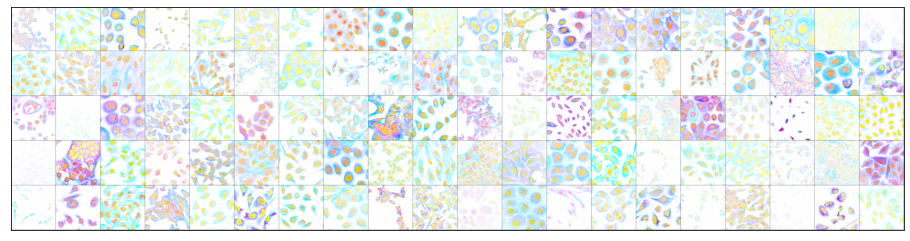

In [13]:
show_batch(train_dl, invert=True)

# Model

In [14]:
############# SETTING UP THE MODEL #############

# Function that calculates the matrix
def F_score(output, label, threshold=0.5, beta=1):
    prob = output > threshold
    label = label > threshold

    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)

In [15]:
#Helper methods for training and validation
class MultilabelImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, targets = batch 
        out = self(images)                      
        loss = F.binary_cross_entropy(out, targets)      
        return loss
    
    def validation_step(self, batch):
        images, targets = batch 
        out = self(images)                           # Generate predictions
        loss = F.binary_cross_entropy(out, targets)  # Calculate loss
        score = F_score(out, targets)
        return {'val_loss': loss.detach(), 'val_score': score.detach() }
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_scores = [x['val_score'] for x in outputs]
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_score']))


In [16]:
# Chaining layers and activation functions
class ProteinCnnModel(MultilabelImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(512, 768, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(768, 768, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(768, 1024, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(1024, 1280, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
            
            

            nn.Flatten(), 
            nn.Linear(1280, 1024),
            nn.ReLU(),
            nn.Linear(1024, 768),
            nn.ReLU(),
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
            nn.Sigmoid()
        )
        
    def forward(self, xb):
        return self.network(xb)


In [17]:
class ProteinCnnModel2(MultilabelImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet18(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 10)
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

In [18]:
# Instantiating the model
model = ProteinCnnModel2()
model

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


ProteinCnnModel2(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [19]:
# Helper Functions

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [20]:
# Checking if GPU is available
device = get_default_device()
device

device(type='cuda')

In [21]:
# Training data loader which moves data to the device
train_dl = DeviceDataLoader(train_dl, device)

# Validation data loader which moves data to the device
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [22]:
# Visualization Functions (not essential)
def try_batch(dl):
    for images, labels in dl:
        print('images.shape:', images.shape)
        out = model(images)
        print('out.shape:', out.shape)
        print('out[0]:', out[0])
        break

try_batch(train_dl)


images.shape: torch.Size([100, 3, 512, 512])
out.shape: torch.Size([100, 10])
out[0]: tensor([0.5250, 0.2631, 0.6177, 0.5887, 0.5239, 0.5524, 0.6275, 0.5488, 0.6594,
        0.6047], device='cuda:0', grad_fn=<SelectBackward>)


In [23]:
############# TRAINING THE MODEL #############

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history


model = to_device(ProteinCnnModel2(), device)

In [24]:
# Evaluate the model
evaluate(model, val_dl)

{'val_loss': 0.8883470892906189, 'val_score': 0.269874632358551}

In [54]:
# Run for a specified number of epochs and with a learning rate
num_epochs = 5
opt_func = torch.optim.Adam
lr = 0.000088

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)


Epoch [0], train_loss: 0.0071, val_loss: 0.3613, val_score: 0.7423



Epoch [1], train_loss: 0.0038, val_loss: 0.3620, val_score: 0.7408



Epoch [2], train_loss: 0.0026, val_loss: 0.3709, val_score: 0.7432



Epoch [3], train_loss: 0.0022, val_loss: 0.3735, val_score: 0.7381



Epoch [4], train_loss: 0.0019, val_loss: 0.3816, val_score: 0.7441


In [26]:
# Run for a specified number of epochs and with a learning rate
num_epochs = 3
opt_func = torch.optim.Adam
lr = 0.00086


history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)


Epoch [0], train_loss: 0.2031, val_loss: 0.2137, val_score: 0.7084



Epoch [1], train_loss: 0.1905, val_loss: 0.2198, val_score: 0.7056



Epoch [2], train_loss: 0.1771, val_loss: 0.2378, val_score: 0.6958


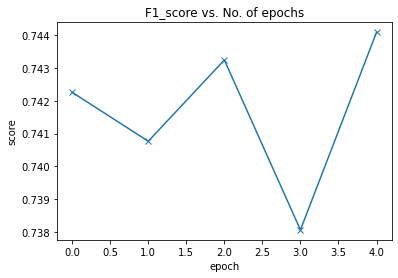

In [55]:
# Plot the learning progress
def plot_score(history):
    scores = [x['val_score'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('F1_score vs. No. of epochs');

plot_score(history)

In [56]:
############# MAKE PREDICTIONS #############

# Function that makes a single preditction
def predict_single(image):
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    prediction = preds[0]
    print("Prediction: ", prediction)
    show_sample(image, prediction)


In [57]:
# Import test samples
test_dataset = HumanProteinDataset(TEST_CSV, TEST_DIR, transform=transform)

Prediction:  tensor([5.7395e-03, 9.4956e-05, 4.1913e-02, 3.3853e-05, 9.9987e-01, 3.8413e-06,
        9.9257e-01, 4.1038e-06, 1.3555e-05, 2.0042e-07], device='cuda:0',
       grad_fn=<SelectBackward>)
Labels: Nucleoplasm(4) Cytosol(6)


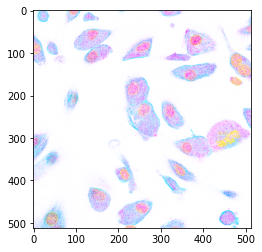

In [58]:
# Make Prediction
predict_single(test_dataset[100][0])

Prediction:  tensor([9.8694e-01, 3.8867e-05, 9.7993e-06, 4.3589e-02, 1.1124e-04, 6.0717e-05,
        4.4791e-04, 3.0205e-06, 1.0668e-04, 7.2397e-06], device='cuda:0',
       grad_fn=<SelectBackward>)
Labels: Mitochondria(0)


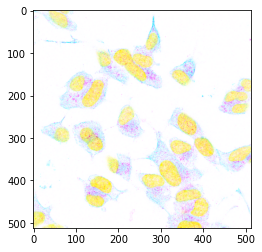

In [59]:
predict_single(test_dataset[74][0])

In [60]:
############# CREATING A SUBMISSION FILE #############

test_dl = DeviceDataLoader(DataLoader(test_dataset, batch_size, num_workers=2, pin_memory=True), device)

In [61]:
@torch.no_grad()
def predict_dl(dl, model):
    torch.cuda.empty_cache()
    batch_probs = []
    for xb, _ in tqdm(dl):
        probs = model(xb)
        batch_probs.append(probs.cpu().detach())
    batch_probs = torch.cat(batch_probs)
    return [decode_target(x) for x in batch_probs]

In [62]:
test_preds = predict_dl(test_dl, model)

In [63]:
submission_df = pd.read_csv(TEST_CSV)
submission_df.Label = test_preds
submission_df.head()

,Image,Label
0,24117,4
1,15322,4
2,14546,6
3,8079,3 6
4,13192,3 4


In [64]:
sub_fname = 'resnet6_submission.csv'

In [65]:
submission_df.to_csv(sub_fname, index=False)
#upload this submission file here: https://www.kaggle.com/c/jovian-pytorch-z2g/submit

In [39]:
############# SAVE TO JOVIAN #############

!pip install jovian --upgrade

     |████████████████████████████████| 63 kB 1.0 MB/s eta 0:00:011
  Created wheel for uuid: filename=uuid-1.30-py3-none-any.whl size=6500 sha256=b865998f3b7f1f0ecb3a38c6c29fa96f9f6f99a8ea33086b438376b3ac8a3f31
  Stored in directory: /root/.cache/pip/wheels/2a/ea/87/dd57f1ecb4f0752f3e1dbf958ebf8b36d920d190425bcdc24d
Successfully built uuid


In [66]:
import jovian

jovian.commit(project='zerogans-protein-competition_v6')

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/yara-sk/zerogans-protein-competition_v6


<IPython.core.display.Javascript object>